# Cross Encoder re_Ranking

In [2]:
import os

# Load the secrets file
current_file_path = os.path.abspath("04_cross_encoder.ipynb")
# print(f"current file: {current_file_path}")

# Get the parent directory of the current file's directory
parent_directory = os.path.dirname(current_file_path)
# print(f"parent file: {parent_directory}")

# Get the parent directory of the parent directory
Child_DIR = os.path.dirname(parent_directory)
# print(f"child file: {Child_DIR}")

# Define the path to the client_secret.json file
microsoft_annual_report_2023 = os.path.join(Child_DIR, '2023_Annual_Report.pdf')
print(f"client file: {microsoft_annual_report_2023}")

client file: d:\Dell\Documents\code\langchain\RAG\chromadb\2023_Annual_Report.pdf


In [3]:
from pypdf import  PdfReader

reader = PdfReader(microsoft_annual_report_2023)
pdf_texts = [page.extract_text().strip() for page in reader.pages]

pdf_texts = [text for text in pdf_texts if text]

print(f"Total number of pages: {len(reader.pages)}")
print(pdf_texts[0])

Total number of pages: 84
1 Dear shareholders, colleagues, customers, and partners,  
We are living through a time of historic challenge and opportunity. As I write this, the world faces ongoing economic, social , 
and geopolitical volatility. At the same time, we have entered a new age of AI that will fundamentally transform productivity  
for every individual, organization, and industry on earth, and help us address some of our most pressing challenges.  
This next generation of AI will reshape every software category and every business, including our own. Forty -eight years 
after its founding, Microsoft remains a consequential company because time and time again —from PC/Server, to 
Web/Internet, to Cloud/Mob ile—we have adapted to technological paradigm shifts. Today, we are doing so once again, as 
we lead this new era.  
Amid this transformation, our mission to empower every person and every organization on the planet to achieve 
more  remains constant. As a company, we believe 

In [4]:
from langchain.text_splitter import  RecursiveCharacterTextSplitter

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(character_split_texts[10])
print(f"\nTotal chunks: {len(character_split_texts)}")

import chromadb.utils.embedding_functions as embedding_functions
# from langchain_openai import OpenAIEmbeddings
import chromadb

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=OPENAI_API_KEY,
                model_name="text-embedding-3-small"
            )

chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("2023_annual_reports", embedding_function=openai_ef)

ids = [str(i) for i in range(len(character_split_texts))]

chroma_collection.add(ids=ids, documents=character_split_texts)
print(chroma_collection.count())


3 Industry  
Across industries, we are rapidly becoming the partner of choice for any organization looking to generate real value from 
AI. In healthcare, for example, we introduced the world’s first fully automated clinical documentation application, DAX 
Copilot. The a pplication helps physicians reduce documentation time by half, freeing them to spend more time face to face 
with patients. And Epic will integrate it directly into its electronic health records system.  
And, in retail, we introduced new tools to help companies manage their day -to-day operations and digitize their physical 
stores.  
Modern work  
We are rapidly evolving Microsoft 365 into an AI -first platform that enables every individual to amplify their creativity and 
productivity, with both our established applications like Office and Teams, as well as new apps like Designer, Stream, and 
Loop. M icrosoft 365 is designed for today’s digitally connected, distributed workforce.

Total chunks: 344
344


In [5]:
chroma_collection = chroma_client.get_collection("2023_annual_reports", embedding_function=openai_ef)
print(chroma_collection.count())

344


In [6]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\open-service-uQHKusx_-py3.12\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\open-service-uQHKusx_-py3.12\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [7]:
def project_embedding(embeddings, umap_transform):
    umap_embedding = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embedding[i] = umap_transform.transform([embedding])
    return umap_embedding

  0%|          | 0/344 [00:00<?, ?it/s]c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\open-service-uQHKusx_-py3.12\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/344 [00:12<1:09:36, 12.18s/it]c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\open-service-uQHKusx_-py3.12\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\open-service-uQHKusx_-py3.12\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\open-service-uQHKusx_-py3.12\Lib\site-packages\sklearn\utils\deprecation.py:151: Futur

(np.float64(-4.24075973033905),
 np.float64(5.600350737571716),
 np.float64(7.746613264083862),
 np.float64(14.052156686782837))

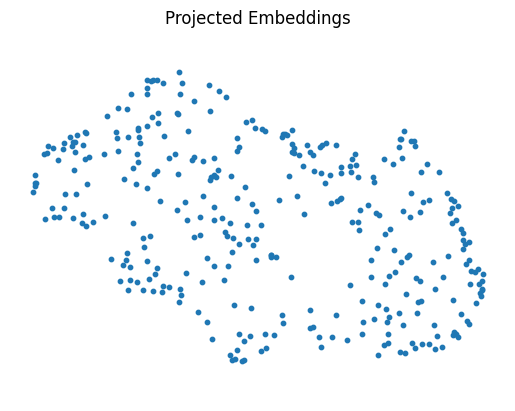

In [8]:
projected_dataset_embeddings = project_embedding(embeddings, umap_transform)

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

In [9]:
query = "What has been the investment in research and development?"
result = chroma_collection.query(query_texts=[query], n_results=10, include=['documents', 'embeddings'])

retrieved_documents = result['documents']

for doc in retrieved_documents[0]:
    print(doc)
    print(" ")

Research and development expenses include payroll, employee benefits, stock -based compensation expense, and other 
headcount -related expenses associated with product development. Research and development expenses also include third -
party development and pro gramming costs and the amortization of purchased software code and services content. Such 
costs related to software development are included in research and development expense until the point that technological 
feasibility is reached, which for our softwa re products, is generally shortly before the products are released to production. 
Once technological feasibility is reached, such costs are capitalized and amortized to cost of revenue over the estimated 
lives of the products.
 
32 Revenue, gross margin, and operating income included an unfavorable foreign currency impact of 3%, 4%, and 6%, 
respectively. Operating expenses included a favorable foreign currency impact of 2%.  
  
OPERATING EXPENSES  
Research and Developme

In [12]:
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [16]:
pairs = [(query, doc) for doc in retrieved_documents[0]]
scores = cross_encoder.predict(pairs)
print("Scores:")
for score in scores:
    print(score)

Scores:
-1.8615972
-1.275606
3.2021267
-3.3135834
-1.0352424
-7.4694576
-6.2696934
-9.689377
-9.840437
-11.0850315


In [20]:
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o+1)

New Ordering:
3
5
2
1
4
7
6
8
9
10


# Re-ranking with Query Expansion

In [21]:
original_query = "What were the most important factors that contributed to increases in revenue?"
generated_queries = [
    "What were the major drivers of revenue growth?",
    "Were there any new product launches that contributed to the increase in revenue?",
    "Did any changes in pricing or promotions impact the revenue growth?",
    "What were the key market trends that facilitated the increase in revenue?",
    "Did any acquisitions or partnerships contribute to the revenue growth?"
]

In [22]:
queries = [original_query] + generated_queries

results = chroma_collection.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents = list(unique_documents)

In [23]:
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

In [24]:
scores = cross_encoder.predict(pairs)

print("Scores:")
for score in scores:
    print(score)

Scores:
-3.2587166
-11.001251
-9.515636
-4.758745
-7.7757726
-5.4563265
-5.5834193
-10.982701
-4.398591
-4.4703174
-2.600357
-10.05552
-4.6858096
-10.19469
-7.9067173
-11.108984
-4.600915
-7.945443


In [28]:

# Sort the scores in descending order and get the indices of the top 5
sorted_indices = np.argsort(scores)[::-1]  # Sort in descending order

# Get the top 5 retrieved documents based on the sorted scores
top_5_documents = [unique_documents[i] for i in sorted_indices[:5]]

# Print the top 5 documents
print("Top 5 Documents Based on CrossEncoder Scores:")
for doc in top_5_documents:
    print(doc)
    print(" ")

Top 5 Documents Based on CrossEncoder Scores:
Year Ended June  30, 2023  2022  2021  
        
United States (a) $ 106,744   $ 100,218   $ 83,953   
Other countries   105,171    98,052    84,135         
Total  $  211,915   $  198,270   $  168,088           
(a) Includes billings to OEMs and certain multinational organizations because of the nature of these businesses and the 
impracticability of determining the geographic source of the revenue.  
Revenue, classified by significant product and service offerings, was as follows:  
  
(In millions)          
        
Year Ended June  30, 2023  2022  2021  
        
Server products and cloud services  $ 79,970   $ 67,350   $ 52,589   
Office products and cloud services   48,728    44,862    39,872   
Windows   21,507    24,732    22,488   
Gaming   15,466    16,230    15,370   
LinkedIn   15,145    13,816    10,289   
Search and news advertising   12,208    11,591    9,267   
Enterprise Services   7,722    7,407    6,943   
Devices   5,52